In [27]:
import pandas as pd

In [28]:
try:
    df = pd.read_parquet("data/processed/events_clean.parquet")
    print("Loaded events_clean.parquet")
except FileNotFoundError:
    df = pd.read_csv("data/processed/events_clean.csv")
    print("Loaded events_clean.csv")

Loaded events_clean.parquet


In [29]:
print("Shape:", df.shape)
print("\nColumn info:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSample rows:")
print(df.head())

Shape: (10000, 5)

Column info:
User ID                         object
Timestamp          datetime64[ns, UTC]
Channel                       category
Campaign                      category
conversion_flag                  int64
dtype: object

Missing values per column:
User ID            0
Timestamp          0
Channel            0
Campaign           0
conversion_flag    0
dtype: int64

Sample rows:
  User ID                 Timestamp         Channel            Campaign  \
0   83281 2025-02-10 07:58:51+00:00           Email  New Product Launch   
1   68071 2025-02-10 23:38:48+00:00      Search Ads         Winter Sale   
2   90131 2025-02-11 10:41:07+00:00    Social Media     Brand Awareness   
3   71026 2025-02-10 08:19:44+00:00  Direct Traffic                   -   
4   94486 2025-02-10 15:15:46+00:00           Email         Retargeting   

   conversion_flag  
0                0  
1                0  
2                1  
3                1  
4                1  


## Policy: Conversion Handling

For all path construction and attribution modeling, we will use:

- [x] **First-conversion only** (truncate events after a user’s first conversion)
- [ ] All conversions (keep every event, including post-conversion)

**Rationale:** We want attribution to credit the journey leading to the first purchase; post-conversion touches will be excluded from paths.


In [30]:
POLICY = "first_conversion"   # change to "all" if you want to keep everything

df = df.sort_values(["User ID", "Timestamp"]).reset_index(drop=True)

if POLICY == "first_conversion":
    # Find each user's first conversion timestamp
    first_conv_ts = (
        df[df["conversion_flag"] == 1]
        .groupby("User ID")["Timestamp"]
        .min()
        .rename("first_conv_ts")
    )
    df = df.join(first_conv_ts, on="User ID")

    before_rows = len(df)
    post_conv = df["first_conv_ts"].notna() & (df["Timestamp"] > df["first_conv_ts"])
    dropped = int(post_conv.sum())
    df = df.loc[~post_conv].copy()

    df = df.drop(columns=["first_conv_ts"])

    print(f"Policy applied: FIRST-CONVERSION ONLY")
    print(f"Dropped post-conversion events: {dropped} (from {before_rows} rows)")
    print(f"Remaining rows: {len(df)}")

elif POLICY == "all":
    print("Policy applied: ALL CONVERSIONS (no truncation)")
else:
    raise ValueError("POLICY must be 'first_conversion' or 'all'")


Policy applied: FIRST-CONVERSION ONLY
Dropped post-conversion events: 5146 (from 10000 rows)
Remaining rows: 4854


In [31]:
from pathlib import Path


In [32]:
df = df.sort_values(["User ID", "Timestamp"]).reset_index(drop=True)

# Build per-user paths + features
paths = (
    df.groupby("User ID")
      .agg(
          Path=("Channel", lambda s: " > ".join(s.tolist())),
          Path_Conversion=("conversion_flag", "max"),
          path_length=("Channel", "size"),
          n_unique_channels=("Channel", "nunique"),
          first_channel=("Channel", "first"),
          last_channel=("Channel", "last"),
          path_start=("Timestamp", "min"),
          path_end=("Timestamp", "max"),
      )
      .reset_index()
)

# Duration in seconds
paths["path_duration"] = (paths["path_end"] - paths["path_start"]).dt.total_seconds().astype("Int64")

# Reorder columns to match your spec
paths = paths[
    ["User ID", "Path", "Path_Conversion", "path_length", "n_unique_channels",
     "first_channel", "last_channel", "path_start", "path_end", "path_duration"]
]

# Save to file
Path("data/processed").mkdir(parents=True, exist_ok=True)
out_path = "data/processed/user_paths.csv"
paths.to_csv(out_path, index=False)

print(f"Saved {len(paths):,} user paths to {out_path}")
print(paths.head())

Saved 2,847 user paths to data/processed/user_paths.csv
  User ID                                   Path  Path_Conversion  \
0   10028                             Search Ads                1   
1   10045               Search Ads > Display Ads                1   
2   10062  Social Media > Direct Traffic > Email                1   
3   10068                             Search Ads                1   
4   10095                            Display Ads                1   

   path_length  n_unique_channels first_channel last_channel  \
0            1                  1    Search Ads   Search Ads   
1            2                  2    Search Ads  Display Ads   
2            3                  3  Social Media        Email   
3            1                  1    Search Ads   Search Ads   
4            1                  1   Display Ads  Display Ads   

                 path_start                  path_end  path_duration  
0 2025-02-10 01:44:12+00:00 2025-02-10 01:44:12+00:00              0  
1 

In [33]:
path_summary = (
    paths.groupby("Path")
         .agg(
             users=("User ID", "count"),
             conv_rate=("Path_Conversion", "mean")
         )
         .reset_index()
         .sort_values("users", ascending=False)
)

print("Top 10 most common paths:")
print(path_summary.head(10))


Top 10 most common paths:
                          Path  users  conv_rate
0               Direct Traffic    277   0.895307
67                 Display Ads    277   0.916968
193                   Referral    259   0.907336
308               Social Media    259   0.903475
128                      Email    252   0.876984
249                 Search Ads    245   0.861224
276      Search Ads > Referral     31   0.806452
76   Display Ads > Display Ads     29   0.827586
299  Search Ads > Social Media     28   0.785714
267         Search Ads > Email     28   0.785714


In [34]:
pathlen_summary = (
    paths.groupby("path_length")
         .agg(users=("User ID", "count"),
              conv_rate=("Path_Conversion", "mean"))
         .reset_index()
         .sort_values("path_length")
)

print("\nConversion rate by path length:")
print(pathlen_summary.head(15))


Conversion rate by path length:
   path_length  users  conv_rate
0            1   1569   0.894200
1            2    783   0.804598
2            3    328   0.725610
3            4    118   0.669492
4            5     34   0.617647
5            6     13   0.692308
6            7      1   0.000000
7            8      1   1.000000


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


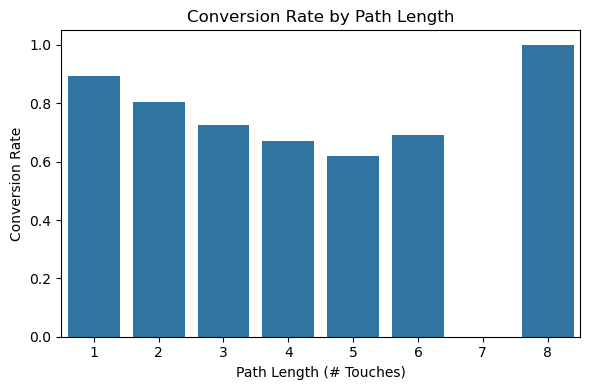

In [36]:
plt.figure(figsize=(6,4))
sns.barplot(data=pathlen_summary, x="path_length", y="conv_rate")
plt.title("Conversion Rate by Path Length")
plt.xlabel("Path Length (# Touches)")
plt.ylabel("Conversion Rate")
plt.tight_layout()
plt.show()


In [37]:
uniqchan_summary = (
    paths.groupby("n_unique_channels")
         .agg(users=("User ID","count"),
              conv_rate=("Path_Conversion","mean"))
         .reset_index()
         .sort_values("n_unique_channels")
)

print("\nConversion rate by number of unique channels:")
print(uniqchan_summary)



Conversion rate by number of unique channels:
   n_unique_channels  users  conv_rate
0                  1   1707   0.885764
1                  2    827   0.787183
2                  3    261   0.708812
3                  4     47   0.595745
4                  5      5   1.000000


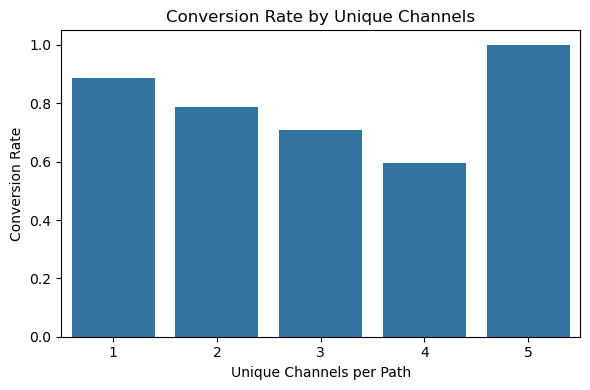

In [38]:
plt.figure(figsize=(6,4))
sns.barplot(data=uniqchan_summary, x="n_unique_channels", y="conv_rate")
plt.title("Conversion Rate by Unique Channels")
plt.xlabel("Unique Channels per Path")
plt.ylabel("Conversion Rate")
plt.tight_layout()
plt.show()

In [39]:
Path("data/processed").mkdir(parents=True, exist_ok=True)

In [40]:
first_all = paths["first_channel"].value_counts().rename_axis("channel").to_frame("users_all")
first_conv = (paths.loc[paths["Path_Conversion"] == 1, "first_channel"]
                   .value_counts().rename_axis("channel").to_frame("users_converters"))
first_touch_table = first_all.join(first_conv, how="outer").fillna(0).astype(int).reset_index()
first_touch_table.to_csv("data/processed/first_touch_table.csv", index=False)


In [41]:
last_all = paths["last_channel"].value_counts().rename_axis("channel").to_frame("users_all")
last_conv = (paths.loc[paths["Path_Conversion"] == 1, "last_channel"]
                  .value_counts().rename_axis("channel").to_frame("users_converters"))
last_touch_table = last_all.join(last_conv, how="outer").fillna(0).astype(int).reset_index()
last_touch_table.to_csv("data/processed/last_touch_table.csv", index=False)


In [42]:
print("✅ Saved first_touch_table.csv and last_touch_table.csv")
first_touch_table.head(), last_touch_table.head()

✅ Saved first_touch_table.csv and last_touch_table.csv


(          channel  users_all  users_converters
 0  Direct Traffic        489               411
 1     Display Ads        492               428
 2           Email        450               374
 3        Referral        486               408
 4      Search Ads        461               371,
           channel  users_all  users_converters
 0  Direct Traffic        488               402
 1     Display Ads        482               415
 2           Email        473               391
 3        Referral        483               412
 4      Search Ads        434               349)

In [43]:
lin_prep = (
    paths.loc[paths["Path_Conversion"] == 1, ["User ID", "Path"]]
         .assign(touches=lambda x: x["Path"].str.split(" > "))
         .explode("touches")
         .rename(columns={"touches": "channel"})
         .reset_index(drop=True)
)

# Optional: add position of the touch in the sequence
lin_prep["touch_pos"] = lin_prep.groupby("User ID").cumcount() + 1
lin_prep.to_csv("data/processed/linear_credit_prep.csv", index=False)

print(f" Saved {len(lin_prep):,} touch rows for linear attribution to data/processed/linear_credit_prep.csv")
lin_prep.head()

 Saved 3,860 touch rows for linear attribution to data/processed/linear_credit_prep.csv


,User ID,Path,channel,touch_pos
0,10028,Search Ads,Search Ads,1
1,10045,Search Ads > Display Ads,Search Ads,1
2,10045,Search Ads > Display Ads,Display Ads,2
3,10062,Social Media > Direct Traffic > Email,Social Media,1
4,10062,Social Media > Direct Traffic > Email,Direct Traffic,2


In [44]:
from collections import Counter


In [45]:
def path_to_edges(path: str, converted: int):
    chans = path.split(" > ") if isinstance(path, str) and path else []
    edges = []
    if not chans:
        return edges
    # Start -> first
    edges.append(("Start", chans[0]))
    # Middle transitions
    for a, b in zip(chans[:-1], chans[1:]):
        edges.append((a, b))
    # Terminal transition
    terminal = "Conversion" if int(converted) == 1 else "Null"
    edges.append((chans[-1], terminal))
    return edges

In [46]:
all_edges = []
for path, path_conversion in paths[["Path", "Path_Conversion"]].itertuples(index=False):
    all_edges.extend(path_to_edges(path, path_conversion))

In [47]:
edge_counts = Counter(all_edges)
transitions = (
    pd.DataFrame([(a, b, w) for (a, b), w in edge_counts.items()],
                 columns=["from_channel", "to_channel", "weight"])
       .sort_values(["from_channel", "to_channel"])
       .reset_index(drop=True)
)

transitions.to_csv("data/processed/transitions_edges.csv", index=False)
print(f" Saved transitions_edges.csv with {len(transitions):,} unique edges")
transitions.head(10)

 Saved transitions_edges.csv with 54 unique edges


,from_channel,to_channel,weight
0,Direct Traffic,Conversion,402
1,Direct Traffic,Direct Traffic,64
2,Direct Traffic,Display Ads,49
3,Direct Traffic,Email,63
4,Direct Traffic,Null,86
5,Direct Traffic,Referral,57
6,Direct Traffic,Search Ads,46
7,Direct Traffic,Social Media,54
8,Display Ads,Conversion,415
9,Display Ads,Direct Traffic,56
